# LIBRARIES

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
from imageio import imread
from skimage.transform import resize

# MULTIPLE CLASSES OF OBJECTS

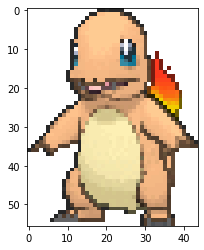

In [3]:
ch = imread('charmander-tight.png')

plt.imshow(ch)
plt.show()

In [4]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, CH_C = ch.shape

In [5]:
def custom_loss(y_true, y_pred):
    # Target is a 5-tuple: (row, col, depth, width, object_appeared)
    bce  = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1]) # Bounding box   loss
    bce2 = binary_crossentropy(y_true[:, -1],  y_pred[:, -1])  # Classification loss
    
    return (2 * bce * y_true[:, -1]) + (0.5 * bce2)

In [6]:
def make_model():
    vgg = tf.keras.applications.VGG16(
        input_shape=[POKE_DIM, POKE_DIM, 3],
        include_top=False,
        weights='imagenet')
    x = Flatten()(vgg.output)
    x = Dense(units=5, activation='sigmoid')(x)
    model = Model(vgg.input, x)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.0001))
    
    return model

In [ ]:
# !wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip
# !unzip -n backgrounds.zip

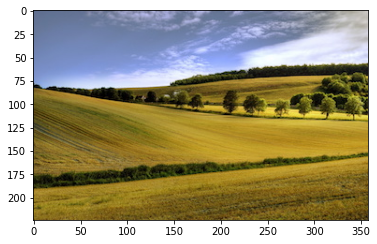

In [8]:
from glob import glob
backgrounds = []

background_files = glob(r'C:\Users\Doan Trong Hieu\Downloads\IMPORTANT\SPECIALIZATION\Artificial_Intelligence\COMPUTER VISION\CODING_COMPUTER_VISION\UDM_Lazy_Programmer_Inc_De_Le_Ad_Co_Vi\backgrounds\*.jpg')
for f in background_files:
    # They may not all be the same size
    bg = np.array(image.load_img(f))
    backgrounds.append(bg)

plt.imshow(backgrounds[3])

In [10]:
def pokemon_generator_bg(batch_size=64):
    # Generate image and targets
    while True:
        # Each epoch will have 50 batches
        for _ in range(50):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 5))
            
            for i in range(batch_size):
                # Select a random background
                bg_idx = np.random.choice(len(backgrounds))
                bg = backgrounds[bg_idx]
                bg_h, bg_w, _ = bg.shape
                rnd_h = np.random.randint(bg_h - POKE_DIM)
                rnd_w = np.random.randint(bg_w - POKE_DIM)
                X[i] = bg[rnd_h:rnd_h+POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()
                
                appear = (np.random.random() < 0.5)
                if appear:
                    # Resize
                    scale = 0.5 + np.random.random()
                    new_height = int(CH_H * scale)
                    new_width  = int(CH_W * scale)
                    obj        = resize(image=ch, 
                                        output_shape=(new_height, new_width),
                                        preserve_range=True).astype(np.uint8)
                    
                    # Flip
                    if (np.random.random() < 0.5):
                        obj = np.fliplr(obj)
                    
                    # Choose a random location to store the object
                    row0 = np.random.randint(POKE_DIM - new_height)
                    col0 = np.random.randint(POKE_DIM - new_width)
                    row1 = row0 + new_height
                    col1 = col0 + new_width
                    
                    # Can't just assign obj to a slice of X since the transparent parts will be black (0)
                    mask      = (obj[:, :, 3] == 0)                 # Find where the pokemon is 0
                    bg_slice  = X[i, row0:row1, col0:col1, :]       # Where we want to place `obj`
                    bg_slice  = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) x (h, w, 3)
                    bg_slice += obj[:, :, :3]                       # `Add` the pokemon to the slice
                    X[i, row0:row1, col0:col1, :] = bg_slice        # Put the slice back
                    
                    # Targets
                    Y[i, 0] = row0 / POKE_DIM           # Top left
                    Y[i, 1] = col0 / POKE_DIM           # Top left
                    Y[i, 2] = (row1 - row0) / POKE_DIM  # Height
                    Y[i, 3] = (col1 - col0) / POKE_DIM  # Width
                
                Y[i, 4] = appear
                
            yield X / 255., Y

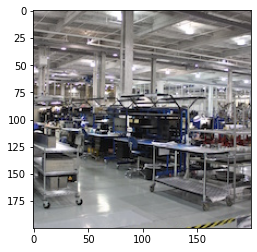

In [17]:
xx, yy = None, None
for x, y in pokemon_generator_bg():
    xx, yy = x, y
    break

plt.imshow(xx[5]);

In [ ]:
model = make_model()
model.fit(pokemon_generator_bg, steps_per_epoch=50, epochs=5)

In [ ]:
from matplotlib.patches import Rectangle

# Make predictions
def make_predictions_bg():
    # Select a random background
    bg_idx = np.random.choice(len(backgrounds))
    bg = backgrounds[bg_idx]
    bg_h, bg_w, _ = bg.shape
    rnd_h = np.random.randint(bg_h - POKE_DIM)
    rnd_w = np.random.randint(bg_w - POKE_DIM)
    x = bg[rnd_h:rnd_h+POKE_DIM, rnd_w:rnd_w+POKE_DIM].copy()
    
    appear = (np.random.random() < 0.5)
    if appear:
        # Resize
        scale = 0.5 + np.random.random()
        new_height = int(CH_H * scale)
        new_width  = int(CH_W * scale)
        obj        = resize(image=ch, 
                            output_shape=(new_height, new_width),
                            preserve_range=True).astype(np.uint8)
        
        # Flip
        if (np.random.random() < 0.5):
            obj = np.fliplr(obj)
        
        # Choose a random location to store the object
        row0 = np.random.randint(POKE_DIM - new_height)
        col0 = np.random.randint(POKE_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width
        
        # Can't just assign obj to a slice of X since the transparent parts will be black (0)
        mask      = (obj[:, :, 3] == 0)                 # Find where the pokemon is 0
        bg_slice  = X[i, row0:row1, col0:col1, :]       # Where we want to place `obj`
        bg_slice  = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) x (h, w, 3)
        bg_slice += obj[:, :, :3]                       # `Add` the pokemon to the slice
        x[row0:row1, col0:col1, :] = bg_slice           # Put the slice back
        
        print('True: ', row0, col0, row1, col1)
    
    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]

    # Plot
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    
    # Draw the box
    if (p[4] > 0.5):
        row0 = int(p[0] * POKE_DIM)
        col0 = int(p[1] * POKE_DIM)
        row1 = int(row0 + p[2] * POKE_DIM)
        col1 = int(col0 + p[3] * POKE_DIM)
        print('Pred: ', row0, col0, row1, col1)
        
        # Top left, Width, Height
        rect = Rectangle((p[1] * POKE_DIM, p[0] * POKE_DIM), p[3] * POKE_DIM, p[2] * POKE_DIM, 
                            linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    else:
        print('Pred: No object!')
    plt.show()

In [ ]:
make_predictions_bg()